In [218]:
!pip install -q geopandas
!apt install -q proj-bin libproj-dev libgeos-dev -y
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip
!pip install rasterio

# Pandas is a package containing additional functions to use data frames in Python
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import warnings
import rasterio
import numpy as np
import seaborn as sns
warnings.simplefilter('ignore')
# These two lines allow the notebook to access the Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# This is the path to the project folder within the Google Drive.
file_path = "/content/drive/My Drive/"

Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.6.2-1build2).
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Mounted at /content/drive


In [23]:
def convert_xy_to_longlat(grid_x, grid_y):
  lon = ((grid_x / 6) - 180)
  lat = -((grid_y / 6) - 90)
  return (lon, lat)

def convert_longlat_to_xy(lon, lat):
  grid_x = int((lon + 180) * 6)
  grid_y = int((-lat + 90) * 6)
  return (grid_x, grid_y)

---
## Notebook 9
# Combining Species and Climate Data

In this notebook we will take our clean species distribution data for a single species and look at the current and predicted climate at the points worldwide where this species has been observed.

This will be the final input data to our species distribution model and also tells us a lot of information about how the species distribution is determined and how it could be affected by climate change, before we apply the model.

You can put any species name here and the whole notebook will run on that species.

In [285]:
species_name = 'Lasius_niger'

Read the cleaned and geo filtered species distribution table

In [286]:
distribution_table = pd.read_csv(file_path + "geo_filtered_main_tables/" + species_name + ".csv", sep="\t")

Read the raster files for current and predicted climate.

For now we'll just look at one model, SSP and timepoint - the most extreme (CanESM5, 2081-2100, ssp585).

In [288]:
model_future = "CanESM5"
timepoint_future = "2081-2100"
ssp_future = "ssp585"

# combine these into a single name to use later
future_ID = model_future + "_" + ssp_future + "_" + timepoint_future

# set the paths to the raster files for current and predicted climate
raster_path_current = file_path + "climate_data/" + "near_present.tif"
raster_path_future = file_path + "climate_data/" + model_future + "/" + ssp_future + "/" + timepoint_future + ".tiff"

# open the raster files
raster_current = rasterio.open(raster_path_current)
raster_future = rasterio.open(raster_path_future)

# convert the data into a matrix, round to 6dp, replace inf with nan
grid_current = raster_current.read()
grid_current = np.round(grid_current, 6)
grid_current[grid_current == float('-inf'), ] = float('nan')
# exclude very low latitudes
grid_current = grid_current[:, 0:930, :]

# same thing for the predicted data
grid_future = raster_future.read()
grid_future = np.round(grid_future, 6)
grid_future[grid_future == float('-inf'), ] = float('nan')
# exclude very low latitudes
grid_future = grid_future[:, 0:930, :]


The climate data is stored in the raster grids, with one observation for each point on the grid.

We want to find which point in the grid corresponds to each of our ant observations, so that we can see the current and predcited values of the 19 bioclim variables at this geographical point.


Convert the latitude and longitude of the points to co-ordinates in the raster grid.

In [289]:
distribution_table['x_pos_raster'] = [convert_longlat_to_xy(x, 0)[0] for x in distribution_table['decimalLongitude']]
distribution_table['y_pos_raster'] = [convert_longlat_to_xy(0, y)[1] for y in distribution_table['decimalLatitude']]

We also need to give each point an ID so we can extract the climate data for that point.

In [290]:
distribution_table['ID'] = ["obs_" +  str(x) for x in np.arange(1, len(distribution_table) + 1)]

Now the distribution table has a column at the end for the x and y grid positions of the point and for the observation ID.

In [291]:
distribution_table

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,infraspecificEpithet,taxonRank,scientificName,verbatimScientificName,verbatimScientificNameAuthorship,countryCode,locality,stateProvince,occurrenceStatus,individualCount,publishingOrgKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,elevation,elevationAccuracy,depth,depthAccuracy,eventDate,day,month,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue,geometry,x_positions,y_positions,correct_country,is_land,x_pos_raster,y_pos_raster,ID
0,1542053353,20fa3e49-f75c-4aad-adcd-6b3882caf6db,c136adc9-f481-4ecd-b6c4-2d83826fdcd0,Animalia,Arthropoda,Insecta,Hymenoptera,Formicidae,Lasius,Lasius niger,NaN,SPECIES,"Lasius niger (Linnaeus, 1758)",Lasius niger,NaN,GB,Strathpeffer,Scotland,present,1.0,13dba6c4-e112-473d-a827-850256bf53c6,57.581390,-4.546360,100.0,NaN,NaN,NaN,NaN,NaN,2008-05-12T00:00:00,12.0,5.0,2008.0,5035785,5035785,HUMAN_OBSERVATION,HBRG,CI0001660000001O,NaN,NaN,Murdo Macdonald,NaN,CC_BY_4_0,NaN,Murdo Macdonald,NaN,NaN,2020-06-26T11:30:58.472Z,NaN,NaN,POINT (-505532.722142413 6402765.472035632),-5.055327e+05,6.402765e+06,True,True,1052,194,obs_1
1,2446764906,dde7e62b-68eb-4a3c-b3d4-f7e4c1cf094a,NSMK-IN-180204766,Animalia,Arthropoda,Insecta,Hymenoptera,Formicidae,Lasius,Lasius niger,NaN,SPECIES,"Lasius niger (Linnaeus, 1758)","Lasius niger (Linnaeus, 1758)",NaN,KR,대전광역시 유성구 금고동 갑천(산림-①),NaN,NaN,NaN,eb07eeb0-3db9-11d9-8439-b8a03c50a862,36.455832,127.394998,NaN,NaN,NaN,NaN,NaN,NaN,2018-04-11T00:00:00,11.0,4.0,2018.0,5035785,5035785,PRESERVED_SPECIMEN,NSMK,IN,NSMK-IN-180204766,NaN,Hwang Jung Ho,NaN,CC_BY_NC_4_0,NaN,NaN,NaN,NaN,2020-06-26T12:00:51.282Z,NaN,GEODETIC_DATUM_ASSUMED_WGS84,POINT (14165693.02172887 4053708.018926457),1.416569e+07,4.053708e+06,True,True,1844,321,obs_2
2,2511409535,17167110-dddf-4c70-adde-2ecc46829521,79390a20-29eb-11e9-8e6d-005056010096,Animalia,Arthropoda,Insecta,Hymenoptera,Formicidae,Lasius,Lasius niger,NaN,SPECIES,"Lasius niger (Linnaeus, 1758)","Lasius niger (Linnaeus, 1758)",NaN,FR,NaN,NaN,Présent,NaN,1928bdf0-f5d2-11dc-8c12-b8a03c50a862,49.420900,-1.756390,5000.0,NaN,NaN,NaN,NaN,NaN,2015-05-03T00:00:00,3.0,5.0,2015.0,5035785,5035785,HUMAN_OBSERVATION,AntArea,NaN,NaN,NaN,Non renseigné (Non renseigné),NaN,CC_BY_NC_4_0,NaN,GUÉRIN Pierrick (INDEPENDANT),NaN,NaN,2020-06-08T16:57:19.285Z,NaN,GEODETIC_DATUM_ASSUMED_WGS84,POINT (-195301.8717927556 5495359.388110043),-1.953019e+05,5.495359e+06,True,True,1069,243,obs_3
3,1085727042,13b70480-bd69-11dd-b15f-b8a03c50a862,CAS:ANTWEB:kbve-srbe:formidabel:27063,Animalia,Arthropoda,Insecta,Hymenoptera,Formicidae,Lasius,Lasius niger,NaN,SPECIES,"Lasius niger (Linnaeus, 1758)",lasius niger,NaN,BE,Brugge,West-Vlaanderen,NaN,NaN,66522820-055c-11d8-b84e-b8a03c50a862,51.204000,3.179000,NaN,NaN,NaN,NaN,NaN,NaN,2011-07-01T00:00:00,1.0,7.0,2011.0,5035785,5035785,PRESERVED_SPECIMEN,CAS,ANTWEB,kbve-srbe:formidabel:27063,NaN,François Vankerkhoven,NaN,CC_BY_4_0,NaN,Jorg Lambrechts,NaN,NaN,2020-07-15T18:02:43.766Z,NaN,GEODETIC_DATUM_ASSUMED_WGS84,POINT (353489.0601911707 5693631.279656716),3.534891e+05,5.693631e+06,True,True,1099,232,obs_4
4,675093151,c2e0fa78-45b5-4e28-919b-4ff81d3304a9,urn:uuid:64e0af1e-9005-4430-9d93-9bdbf65b267c,Animalia,Arthropoda,Insecta,Hymenoptera,Formicidae,Lasius,Lasius niger,NaN,SPECIES,"Lasius niger (Linnaeus, 1758)","Lasius niger (Linnaeus, 1758)",NaN,NO,Vindafjord Vats,NaN,NaN,NaN,ecc5cd9e-2d25-4b8d-89c8-a0711eee813b,59.493364,5.727805,NaN,NaN,NaN,NaN,NaN,NaN,1939-01-01T00:00:00,1.0,1.0,1939.0,5035785,5035785,PRESERVED_SPECIMEN,MUST,Insecta,6304,NaN,"Holgersen, Holger",NaN,CC_BY_4_0,NaN,"Holgersen, Holger",NaN,NaN,2020-06-08T16:33:47.117Z,NaN,GEODETIC_DATUM_ASSUMED_WGS84;COUNTRY_DERIVED_F...,POINT (636903.5565927299 6615367.514303625),6.369036e+05,6.615368e+06,True,T

We can make a dictionary of the grid co-ordinates of each point in the grid.

In [292]:
obs_coord_dict = dict()
for obs_ID, x, y in zip(distribution_table['ID'],
                        distribution_table['x_pos_raster'],
                        distribution_table['y_pos_raster']):
  obs_coord_dict[obs_ID] = ((x, y))

In [293]:
obs_coord_dict

{'obs_1': (1052, 194),
 'obs_2': (1844, 321),
 'obs_3': (1069, 243),
 'obs_4': (1099, 232),
 'obs_5': (1114, 183),
 'obs_6': (1084, 225),
 'obs_7': (1108, 232),
 'obs_8': (1889, 330),
 'obs_9': (1114, 234),
 'obs_10': (1158, 205),
 'obs_11': (1082, 223),
 'obs_12': (1109, 233),
 'obs_13': (1083, 225),
 'obs_14': (1107, 227),
 'obs_15': (1114, 234),
 'obs_16': (1101, 234),
 'obs_17': (1146, 235),
 'obs_18': (1132, 182),
 'obs_19': (1117, 225),
 'obs_20': (1171, 184),
 'obs_21': (1088, 227),
 'obs_22': (1051, 227),
 'obs_23': (1855, 326),
 'obs_24': (1158, 205),
 'obs_25': (1219, 180),
 'obs_26': (1145, 201),
 'obs_27': (1113, 235),
 'obs_28': (1096, 233),
 'obs_29': (1133, 237),
 'obs_30': (1189, 184),
 'obs_31': (1132, 285),
 'obs_32': (456, 319),
 'obs_33': (1107, 233),
 'obs_34': (1131, 245),
 'obs_35': (1121, 231),
 'obs_36': (1116, 225),
 'obs_37': (1059, 226),
 'obs_38': (1110, 233),
 'obs_39': (1184, 164),
 'obs_40': (1115, 232),
 'obs_41': (1087, 223),
 'obs_42': (409, 297),
 'o

We can also make a grid with a 1 in each position that the species has been observed in and a 0 in every other position.

In [294]:
# make a grid the same shape and size as the raster grids
dist_grid = np.empty(np.shape(grid_current[0]), dtype=int)

# fill it with zeros
dist_grid.fill(0)

In [295]:
# replace 0 with 1 where an ant has been seen
for obs_ID in obs_coord_dict:
  x, y = obs_coord_dict[obs_ID]
  dist_grid[y, x] = 1

Plot these points on a grid just to check they look right - they should resemble the map in ```filtered_maps/Lasinus_niger.png```

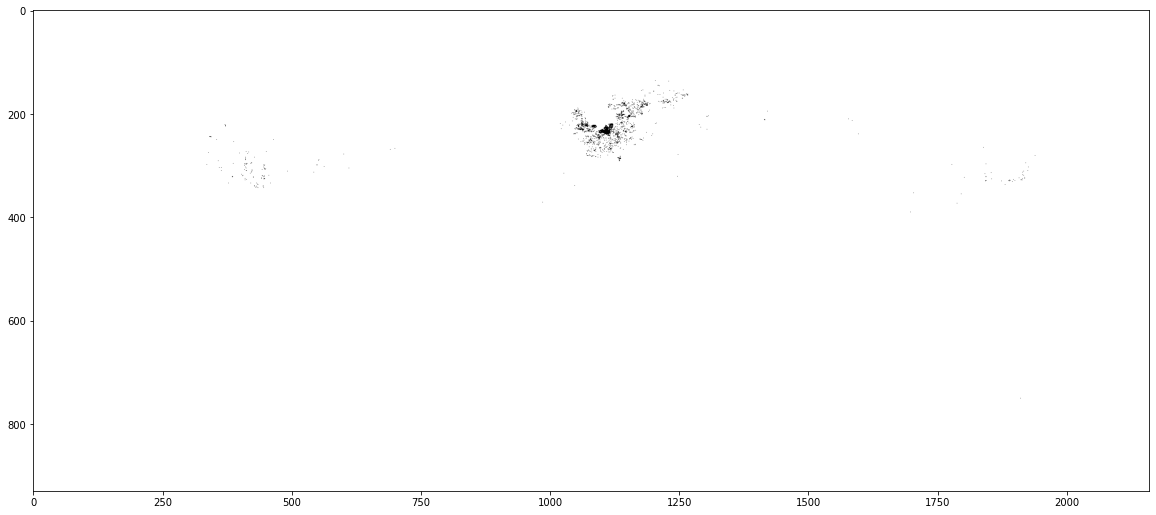

In [296]:
plt.figure(figsize=(20, 20))
plt.imshow(dist_grid, cmap='binary')

The points are tiny because each grid square is tiny - but they look like they are in the right places.



Next, we extract the climate data points for each of the bioclim variables for all the squares where the ants are found.

We will put the bioclim variable names into a dictionary again just for convenience.

In [297]:
bioclim = pd.read_csv(file_path + "bioclim.tsv", sep="\t")
bioclim_name = dict(zip(bioclim['variable_number'], bioclim['name']))

In [298]:
bioclim_name

{1: 'Annual_Mean_Temperature',
 2: 'Mean_Diurnal_Range_(Mean_of_monthly_(max_temp_-_min_temp))',
 3: 'Isothermality_(BIO2/BIO7)_(×100)',
 4: 'Temperature_Seasonality_(standard_deviation_×100)',
 5: 'Max_Temperature_of_Warmest_Month',
 6: 'Min_Temperature_of_Coldest_Month',
 7: 'Temperature_Annual_Range_(BIO5-BIO6)',
 8: 'Mean_Temperature_of_Wettest_Quarter',
 9: 'Mean_Temperature_of_Driest_Quarter',
 10: 'Mean_Temperature_of_Warmest_Quarter',
 11: 'Mean_Temperature_of_Coldest_Quarter',
 12: 'Annual_Precipitation',
 13: 'Precipitation_of_Wettest_Month',
 14: 'Precipitation_of_Driest_Month',
 15: 'Precipitation_Seasonality_(Coefficient_of_Variation)',
 16: 'Precipitation_of_Wettest_Quarter',
 17: 'Precipitation_of_Driest_Quarter',
 18: 'Precipitation_of_Warmest_Quarter',
 19: 'Precipitation_of_Coldest_Quarter'}

Extract the observation and prediction of each bioclim variable for each grid point where an ant has been observed.

In [309]:
raster_results = []

# for each observation
for obs_ID in obs_coord_dict:
  # get the co-ordinates of the observation
  x, y = obs_coord_dict[obs_ID]

  # make a list to store the results for this observation
  this_obs = [obs_ID]
  # for each bioclim variable
  for i in range(0, 19):
    # get the grid for this variable
    var_grid = grid_current[i]
    
    # get the value of this variable at this grid point
    gridpoint_current = var_grid[y, x]

    # store the results for this observation
    this_obs.append(gridpoint_current)
    
  raster_results.append(this_obs)

results = pd.DataFrame(raster_results, columns=['obs_ID'] + [bioclim_name[x] for x in range(1, 20)])
results.to_csv(file_path + "species_plus_climate/" + species_name + "_observations.tsv", sep="\t", index=None)

In [301]:
results

,obs_ID,Annual_Mean_Temperature,Mean_Diurnal_Range_(Mean_of_monthly_(max_temp_-_min_temp)),Isothermality_(BIO2/BIO7)_(×100),Temperature_Seasonality_(standard_deviation_×100),Max_Temperature_of_Warmest_Month,Min_Temperature_of_Coldest_Month,Temperature_Annual_Range_(BIO5-BIO6),Mean_Temperature_of_Wettest_Quarter,Mean_Temperature_of_Driest_Quarter,Mean_Temperature_of_Warmest_Quarter,Mean_Temperature_of_Coldest_Quarter,Annual_Precipitation,Precipitation_of_Wettest_Month,Precipitation_of_Driest_Month,Precipitation_Seasonality_(Coefficient_of_Variation),Precipitation_of_Wettest_Quarter,Precipitation_of_Driest_Quarter,Precipitation_of_Warmest_Quarter,Precipitation_of_Coldest_Quarter
0,obs_1,7.266677,7.179354,40.869576,402.733551,16.948999,-0.617500,17.566500,3.314958,8.691999,12.420708,2.689667,2049.0,238.0,100.0,31.205036,700.0,319.0,365.0,634.0
1,obs_2,12.054636,10.667105,29.052814,993.988525,29.464500,-7.251750,36.716251,23.933167,-0.601083,23.933167,-0.601083,1302.0,303.0,28.0,86.070992,732.0,92.0,732.0,92.0
2,obs_3,11.192121,5.824338,34.494759,409.970703,20.567352,3.682647,16.884705,7.577647,16.173578,16.459902,6.526078,876.0,112.0,43.0,31.686760,312.0,141.0,166.0,273.0
3,obs_4,10.298016,6.616207,32.135494,518.524597,21.736591,1.148120,20.588470,7.817042,6.261904,16.683792,4.156433,783.0,85.0,46.0,18.952810,243.0,149.0,198.0,184.0
4,obs_5,6.520634,6.073756,30.592840,517.754089,17.529577,-2.323944,19.853521,4.068780,8.636385,13.109343,0.626385,2304.0,281.0,100.0,34.922852,823.0,322.0,443.0,676.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8704,obs_8705,11.480333,8.685458,38.467823,529.504333,24.651501,2.073000,22.578501,6.073000,18.173834,18.173834,5.321458,686.0,72.0,40.0,17.529890,208.0,132.0,132.0,202.0
8705,obs_8706,9.251281,7.778062,38.358566,464.384705,20.955250,0.678000,20.277250,4.718375,5.766666,15.197333,3.909834,595.0,58.0,37.0,11.815346,163.0,127.0,157.0,148.0
8706,obs_8707,10.001291,7.637958,37.443726,479.451752,21.690250,1.291750,20.398500,10.636875,6.257334,16.140459,4.514500,618.0,63.0,37.0,13.554139,175.0,131.0,158.0,147.0
8707,obs_8708,11.374271,9.092292,38.216557,563.373779,25.181250,1.389750,23.791500,8.100250,18.486126,18.486126,4.753042,713.0,71.0,46.0,13.620741,201.0,146.0,146.0,192.0


Summarising these results already tells us quite a lot.

```results.max()```, ```results.min()``` and ```results.mean()``` tell us the maximum, minimum and mean values of each column - this gives us an idea about the maximum and minimum values of each variable at which this ant can survive.

In [303]:
results.max()

obs_ID                                                        obs_999
Annual_Mean_Temperature                                       18.8307
Mean_Diurnal_Range_(Mean_of_monthly_(max_temp_-_min_temp))    19.3561
Isothermality_(BIO2/BIO7)_(×100)                              51.1248
Temperature_Seasonality_(standard_deviation_×100)             1500.69
Max_Temperature_of_Warmest_Month                              35.4145
Min_Temperature_of_Coldest_Month                              9.64688
Temperature_Annual_Range_(BIO5-BIO6)                           51.791
Mean_Temperature_of_Wettest_Quarter                            24.541
Mean_Temperature_of_Driest_Quarter                            25.6414
Mean_Temperature_of_Warmest_Quarter                           25.9773
Mean_Temperature_of_Coldest_Quarter                           13.2461
Annual_Precipitation                                             2823
Precipitation_of_Wettest_Month                                    362
Precipitation_of_Dri

In [304]:
results.min()

obs_ID                                                          obs_1
Annual_Mean_Temperature                                      -2.11022
Mean_Diurnal_Range_(Mean_of_monthly_(max_temp_-_min_temp))    3.38056
Isothermality_(BIO2/BIO7)_(×100)                              18.9431
Temperature_Seasonality_(standard_deviation_×100)             313.434
Max_Temperature_of_Warmest_Month                               12.133
Min_Temperature_of_Coldest_Month                             -23.6103
Temperature_Annual_Range_(BIO5-BIO6)                          12.1022
Mean_Temperature_of_Wettest_Quarter                          -8.38042
Mean_Temperature_of_Driest_Quarter                           -14.8167
Mean_Temperature_of_Warmest_Quarter                           7.81354
Mean_Temperature_of_Coldest_Quarter                          -16.1903
Annual_Precipitation                                              141
Precipitation_of_Wettest_Month                                     15
Precipitation_of_Dri

In [305]:
results.mean()

Annual_Mean_Temperature                                         9.248750
Mean_Diurnal_Range_(Mean_of_monthly_(max_temp_-_min_temp))      7.858137
Isothermality_(BIO2/BIO7)_(×100)                               33.892404
Temperature_Seasonality_(standard_deviation_×100)             576.925837
Max_Temperature_of_Warmest_Month                               22.250174
Min_Temperature_of_Coldest_Month                               -1.066220
Temperature_Annual_Range_(BIO5-BIO6)                           23.316394
Mean_Temperature_of_Wettest_Quarter                             9.618791
Mean_Temperature_of_Driest_Quarter                              6.011156
Mean_Temperature_of_Warmest_Quarter                            16.492524
Mean_Temperature_of_Coldest_Quarter                             2.437793
Annual_Precipitation                                          797.122862
Precipitation_of_Wettest_Month                                 87.757492
Precipitation_of_Driest_Month                      

We can see several things in this data.


* Lasius niger lives in locations with a mean annual temperature between -2oC and 18oC, with a mean of 9oC.

* The warmest temperature it has been observed at - the maximum value for "Max_Temperature_of_Warmest_Month" is 35oC

* The coldest temperature it has been observed at - the minimum value for "Minimum_Temperature_of_Coldest_Month" is -23oC.

* This suggests L. niger prefers quite cold temperatures but can survive moderately warm peak temperatures.

* It lives in regions with a minimum annual precipitation of 141mm and a maximum of 2823mm (mean 797)- this is a very wide range so its distribution probably isn't massively affected by precipitation.

* The minimum of precipitation in driest month is only 1mm - it doesn't require much rainfall at all in dry seasons.

* The maximum of precipitation in the wettest month is 362mm - it can survive quite high rainfall peaks.

* The distribution of L. niger is probably limited more by temperature than precipitation.


To get more information about these, we can compare them to the worldwide values for the same variables.

We can also start to predict how this species may be affected by climate change by looking at the predicted worldwide values of these variables in the future.

At the moment we'll just stick to one model and SSP - the most extreme (SSP5 and CanESM5).

We can calculate the summary statistics for the current observed climate data and the predictions under this model and put them into a table.

In [306]:
# list to store the results
info_list = []
# for each variable
for i in range(0, 19):
  var_nam = bioclim_name[i+1]
  # np.nanmean just calculates the mean ignoring NA values
  # find the worldwide mean of the current data for this variable
  mean_current = np.nanmean(grid_current[i])
  # find the worldwide mean of the predicted data for this variable
  mean_predicted = np.nanmean(grid_future[i])

  # same but for maximum and minimum
  min_current = np.nanmin(grid_current[i])
  min_predicted = np.nanmin(grid_future[i])

  max_current = np.nanmax(grid_current[i])
  max_predicted = np.nanmax(grid_future[i])

  # store the results
  info_list.append([var_nam,
                    mean_current, mean_predicted,
                    min_current, min_predicted,
                    max_current, max_predicted])
  

# convert to pandas
info_tab = pd.DataFrame(info_list, columns=['Variable',
                                            'Mean_Current_Worldwide',
                                            'Mean_Predicted_Worldwide ' + future_ID,
                                            'Min_Current_Worldwide',
                                            'Min_Predicted_Worldwide ' + future_ID,
                                            'Max_Current_Worldwide',
                                            'Max_Predicted_Worldwide ' + future_ID])

# save the table
info_tab.to_csv(file_path + "species_plus_climate" + species_name + "_climate_info.tsv", sep="\t", index=None)

In [307]:
info_tab

,Variable,Mean_Current_Worldwide,Mean_Predicted_Worldwide CanESM5_ssp585_2081-2100,Min_Current_Worldwide,Min_Predicted_Worldwide CanESM5_ssp585_2081-2100,Max_Current_Worldwide,Max_Predicted_Worldwide CanESM5_ssp585_2081-2100
0,Annual_Mean_Temperature,8.355878,18.153156,-27.218531,-16.000782,30.987640,39.753384
1,Mean_Diurnal_Range_(Mean_of_monthly_(max_temp_...,10.852686,9.832422,1.000000,-2.141667,21.147543,21.176041
2,Isothermality_(BIO2/BIO7)_(×100),38.750660,35.827057,9.131122,-31.592037,100.000000,95.481926
3,Temperature_Seasonality_(standard_deviation_×100),845.268127,773.742126,0.000000,6.894782,2363.845947,2207.443848
4,Max_Temperature_of_Warmest_Month,25.620016,34.654606,-9.000000,-5.606250,48.082748,58.293751
5,Min_Temperature_of_Coldest_Month,-8.314027,3.117700,-49.723999,-34.799999,26.299999,31.100000
6,Temperature_Annual_Range_(BIO5-BIO6),33.934048,31.536901,1.000000,3.000000,72.301750,66.949997
7,Mean_Temperature_of_Wettest_Quarter,15.162353,22.851284,-37.673786,-25.457293,37.704792,47.507290
8,Mean_Temperature_of_Driest_Quarter,2.946142,13.944634,-42.148792,-26.579166,37.433582,48.394791
9,Mean_Temperature_of_Warmest_Quarter,18.648592,27.625185,-13.127791,-6.882292,38.216167,48.730209


We can also plot the distribution of these variables for the current worldwide data (green), predicted 2080-2100 data (red) and the points where this ant is observed (blue).

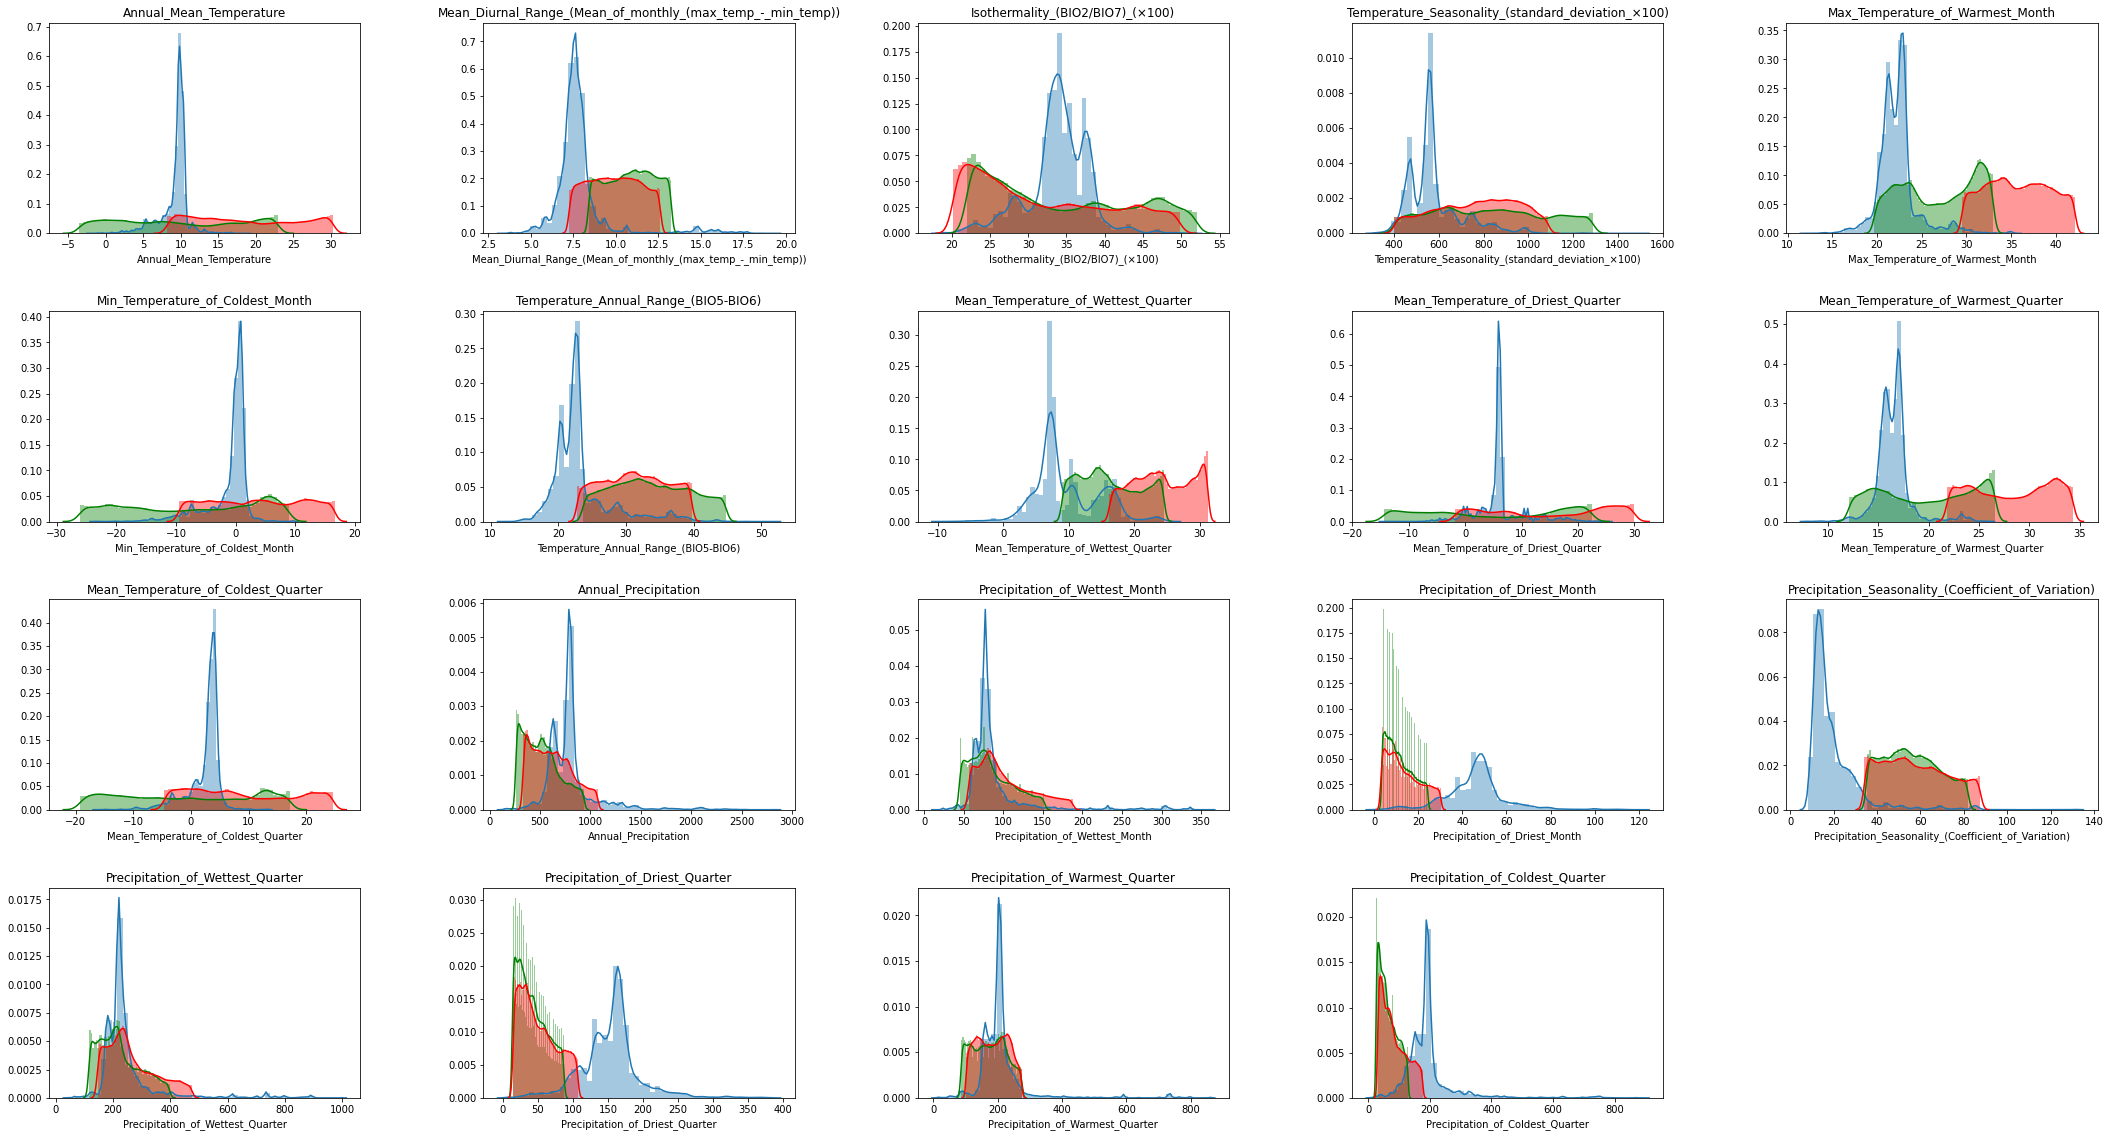

In [308]:
f = plt.figure(figsize=(30, 40))

# for each bioclim variable
for var in range(0, 19):
  a = f.add_subplot(10, 5, var+1)

  # this is just a different plotting function
  # sns.distplot shows the distribution of the points
  sns.distplot(results[bioclim_name[var+1]], ax=a)

  # for the predicted and future data, we're just plotting the middle
  # 50% of values - this just makes the information a bit
  # easier to see on the graphs
  iqr_1_current = np.nanpercentile(grid_current[var], 25)
  iqr_2_current = np.nanpercentile(grid_current[var], 75)
  current = grid_current[var][(grid_current[var] > iqr_1_current) & (grid_current[var] < iqr_2_current)]
  iqr_1_future = np.nanpercentile(grid_future[var], 25)
  iqr_2_future = np.nanpercentile(grid_future[var], 75)
  future = grid_future[var][(grid_future[var] > iqr_1_future) & (grid_future[var] < iqr_2_future)] 
  
  # add the current and future worldwide distributions to the graph
  sns.distplot(current, ax=a, color='green')
  sns.distplot(future, ax=a, color='red')

  plt.title(bioclim_name[var+1])
plt.tight_layout(pad=3)
plt.savefig(file_path + "species_plus_climate/" + species_name + ".png", dpi=300, bbox_inches='tight')

This gives more information which we can compare to what we already know.

* Lasius niger lives in locations with a mean annual temperature between -2oC and 18oC, with a mean of 9oC.  It is very much more common at temperatures of 7-12oC.

** The current worldwide value of this statistic -27 to 30 with a mean of 8oC - L. niger can currently survive in large areas of the planet, this is reflected in its wide geographic distribution.  Its prefered temperature is in the middle of the current distribution.
** The predicted worldwide value of this statistic is -16 to 39 with a mean of 18oC - L. niger may not survive as well in these warmer conditions.  Its preferred temperature is well to the left of the predicted distribution.


* The warmest temperature L. niger has been observed at - the maximum value for "Max_Temperature_of_Warmest_Month" is 35oC. 
** The current worldwide maximum for this statistic is 48oC and the current worldwide mean is 25oC - most places in the world do not regularly get as warm as 35oC.  Looking at the graph, it prefers the lower end of the current distribution.
** The predicted worldwide maximum is 48oC and predicted worldwide mean is 35oC - many places would become to warm in their hottest period for L. niger to survive.  The predicted distribution of warmest temperatures is largely too hot for this species.

* The coldest temperature L. niger has been observed at - the minimum value for "Minimum_Temperature_of_Coldest_Month" is -23oC.
** The current worldwide minimum for this statistic is -49 and the mean -8oC - most places are rarely too cold for L. niger.  It prefers regions with a higher minimum.
** The predicted worldwide minimum is -34 and the mean is 3 - many areas which are currently too cold for L. niger will become habitable. 

* L. niger lives in regions with a minimum annual precipitation of 141mm and a maximum of 2823mm (mean 797)- this is a very wide range so its distribution probably isn't massively affected by precipitation.  It prefers slightly wetter conditions.
** The current annual mean precipitation worldwide is 714, max 111191, min 0 - most places have precipitation at which L. niger can survive.
** The predictions for these are similar - mean 820, max 13572, min 0 - this shouldn't have a big effect on L. niger distribution.

* The minimum of precipitation in driest month where L.niger is present only 1mm - it doesn't require much rainfall at all in dry seasons.  However, it is much more commonly seen in wetter regions.
** The current and predicted values are very similar so it is unlikely this variable will massively affect L. niger in the future.

* The maximum of precipitation in the wettest month where L. niger is present is 362mm - it can survive quite high rainfall peaks.
** The maximum current worldwide value is 2381 - this is likely to be too high for L.niger.  However, looking at the graph, it can survive the maximum rainfall in most regions.
** The maximum predicted worldwide value in 2080-2100 is 4991 - this is also likely to be too high, but looking at the graph most regions will still have survivable rainfall.
